In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import keras
from keras import layers

# AE Architecture

In [21]:
input_img = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

decoder_input = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(decoder_input)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.save_weights('initial_model.h5')

In [22]:
from stacked_mnist import StackedMNISTData, DataMode
from tensorflow import keras

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

In [23]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 37s 77ms/step - loss: 0.2277 - val_loss: 0.1440
Epoch 2/10
469/469 [==============================] - 35s 74ms/step - loss: 0.1299 - val_loss: 0.1179
Epoch 3/10
469/469 [==============================] - 35s 75ms/step - loss: 0.1123 - val_loss: 0.1047
Epoch 4/10
469/469 [==============================] - 36s 76ms/step - loss: 0.1018 - val_loss: 0.0975
Epoch 5/10
469/469 [==============================] - 34s 73ms/step - loss: 0.0955 - val_loss: 0.0917
Epoch 6/10
469/469 [==============================] - 34s 74ms/step - loss: 0.0913 - val_loss: 0.0881
Epoch 7/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0882 - val_loss: 0.0854
Epoch 8/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0858 - val_loss: 0.0833
Epoch 9/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0839 - val_loss: 0.0822
Epoch 10/10
469/469 [==============================] - 35s 75ms/step - loss: 0.082

# AE Reconstruction Results

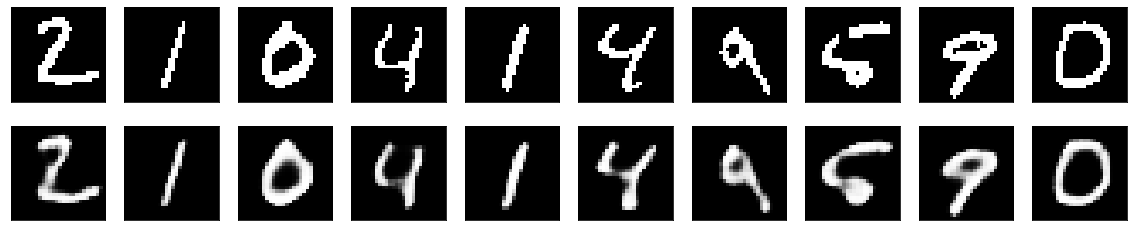

In [24]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
from verification_net import VerificationNet

net = VerificationNet(force_learn=False, file_name="../models/verification_model")
img, labels = generator.get_random_batch(training=False, batch_size=25000)
decoded_imgs = autoencoder.predict(img)
_, acc_ae = net.check_predictability(data=decoded_imgs, correct_labels=labels)
_, acc_orig = net.check_predictability(data=img, correct_labels=labels)
print(f"Accuracy AE: {100 * acc_ae:.2f}%")
print(f"Accuracy Original: {100 * acc_orig:.2f}%")


/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy AE: 77.07%
Accuracy Original: 95.62%


# AE as a generative model

In [31]:
import numpy as np

z = np.random.randn(100, 4, 4, 8)

decoder = keras.Model(decoder_input, decoded)
decoded_z = decoder.predict(z)

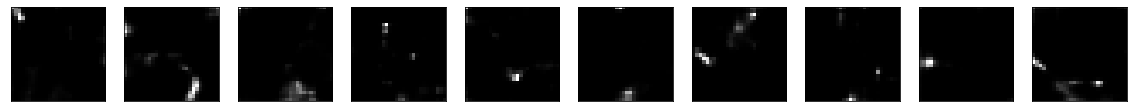

In [32]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(decoded_z[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# AE as an anomaly detector

In [ ]:
autoencoder.load_weights('initial_model.h5')

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
reconstructed = autoencoder.predict(x_test)


In [ ]:
from tensorflow.keras.losses import binary_crossentropy
losses = binary_crossentropy(x_test, reconstructed).numpy()
largest_loss = np.argpartition(losses, -5)[-5:]

plt.figure(figsize=(5, 4))
for i in range(1, 5):
    # Display original
    ax = plt.subplot(i, 5)
    plt.imshow(decoded_z[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()